In [1]:
import torch.nn as nn
import torch
!pip install tiktoken

In [2]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale= nn.Parameter(torch.ones(emb_dim))
    self.shift= nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean= x.mean(dim=-1,keepdim=True)
    var= x.var(dim=-1,keepdim=True,unbiased=False)
    norm_x= (x-mean)/torch.sqrt(var+self.eps)
    return self.scale * norm_x + self.shift

In [3]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()
    assert(d_out%num_heads==0),\
    "d_out must be divisible by num_heads"
    self.d_out= d_out
    self.num_heads= num_heads
    self.head_dim= d_out//num_heads
    self.W_query= nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key= nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value= nn.Linear(d_in,d_out,bias=qkv_bias)
    self.out_proj=nn.Linear(d_out,d_out) #linear layer to combine head outputs
    self.dropout= nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

  def forward(self,x):
    b,num_tokens,d_in= x.shape
    keys= self.W_key(x) # (b,num_tokens,d_out)
    queries= self.W_query(x)
    values= self.W_value(x)
    # we implicitly split matrix by adding num_heads dim
    keys= keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries= queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values= values.view(b,num_tokens,self.num_heads,self.head_dim)
    #transpose (b,num_tokens,num_heads,head_dim)->(b,num_heads,num_tokens,head_dim)
    #This dimension helps in parallel computation
    keys= keys.transpose(1,2)
    queries=queries.transpose(1,2)
    values= values.transpose(1,2)
    attn_scores= queries @ keys.transpose(2,3) #(b,num_heads,num_tokens,num_tokens)
    mask_bool= self.mask.bool()[:num_tokens,:num_tokens]
    attn_scores.masked_fill_(mask_bool,-torch.inf)
    attn_weights= torch.softmax(attn_scores/keys.shape[-1]**0.5,dim=-1)
    attn_weights= self.dropout(attn_weights)
    #context vec before tanspose (b,num_heads,num_token,head_dim)
    #after transpose (b,num_tokens,num_heads,head_dim)
    #merging the heads back
    context_vec= (attn_weights @ values).transpose(1,2)
    context_vec= context_vec.contiguous().view(b,num_tokens,self.d_out)
    context_vec= self.out_proj(context_vec)
    return context_vec

In [4]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)))*(x+0.044715*torch.pow(x,3)))


In [5]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers= nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"])
    )

  def forward(self,x):
    return self.layers(x)

In [6]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att= MultiHeadAttention(
        d_in= cfg["emb_dim"],
        d_out= cfg["emb_dim"],
        context_length= cfg["context_length"],
        num_heads= cfg["n_heads"],
        dropout= cfg["drop_rate"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.ff= FeedForward(cfg)
    self.norm1= LayerNorm(cfg["emb_dim"])
    self.norm2= LayerNorm(cfg["emb_dim"])
    self.drop_shortcut= nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    shortcut=x
    x= self.norm1(x)
    x= self.att(x)
    x= self.drop_shortcut(x)
    x=shortcut+x

    shortcut=x
    x= self.norm2(x)
    x= self.ff(x)
    x= self.drop_shortcut(x)
    x=x+shortcut

    return x


In [7]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}
model = GPTModel(GPT_CONFIG_124M)
model.eval();

In [9]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
  for _ in range(max_new_tokens):
    idx_cond= idx[:,-context_size:]
    with torch.no_grad():
      logits= model(idx_cond)
    logits= logits[:,-1,:]
    probas= torch.softmax(logits,dim=-1)
    idx_next= torch.argmax(probas,dim=-1,keepdim=True)
    idx= torch.cat((idx,idx_next),dim=1)
  return idx

In [10]:
import tiktoken
def text_to_token_ids(text,tokenizer):
  encoded= tokenizer.encode(text,allowed_special={'<|endoftext|>'})
  encoded_tensor= torch.tensor(encoded).unsqueeze(0) #Adds a dimension of size 1 at the specified position.
  return encoded_tensor

def token_ids_to_text(token_ids,tokenizer):
  flat= token_ids.squeeze(0)
  return tokenizer.decode(flat.tolist())

start_context= "Every effort moves you"
tokenizer= tiktoken.get_encoding("gpt2")
token_ids= generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context,tokenizer),
    max_new_tokens=10,
    context_size= GPT_CONFIG_124M["context_length"]
)
print(token_ids_to_text(token_ids,tokenizer))

Every effort moves you Gambleя Myr PillTeen dresses Psychology wor ridic Jehovah


In [11]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [12]:
with torch.no_grad():
  logits= model(inputs)

probas= torch.softmax(logits,dim=-1)
print(probas.shape)
print(probas)

torch.Size([2, 3, 50257])
tensor([[[1.8680e-05, 1.8059e-05, 3.3356e-05,  ..., 1.7160e-05,
          1.1289e-05, 1.1339e-05],
         [6.3086e-06, 1.7280e-05, 1.6449e-05,  ..., 1.4804e-05,
          1.5839e-05, 4.7729e-06],
         [1.6625e-05, 1.1277e-05, 1.6356e-05,  ..., 7.5937e-06,
          7.7565e-06, 2.1299e-05]],

        [[4.7255e-06, 2.3671e-05, 3.2888e-05,  ..., 9.8001e-06,
          8.0078e-06, 3.5715e-05],
         [8.4019e-06, 1.9870e-05, 8.0899e-06,  ..., 8.6421e-06,
          1.6314e-05, 9.8128e-06],
         [2.4459e-05, 8.3489e-06, 1.1318e-05,  ..., 7.4059e-06,
          1.1175e-05, 3.0409e-05]]])


In [13]:
token_ids = torch.argmax(probas,dim=-1,keepdim=True)
print(token_ids)

tensor([[[ 2210],
         [39383],
         [17114]],

        [[32834],
         [13031],
         [14003]]])


In [14]:
batch_no=0
target_probas_1= probas[batch_no,[0,1,2],targets[batch_no]]
print(target_probas_1)

batch_no=1
target_probas_2= probas[batch_no,[0,1,2],targets[batch_no]]
print(target_probas_2)

tensor([2.9408e-05, 1.2241e-05, 8.7907e-06])
tensor([2.9447e-05, 8.4477e-06, 2.7971e-05])


In [15]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.4342, -11.3107, -11.6418, -10.4329, -11.6816, -10.4843])


In [16]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.9976)


In [17]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.9976)


In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.9976)


In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(59731.5625)


In [21]:
import os
import urllib.request
file_path= "/content/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
if not os.path.exists(file_path):
  with urllib.request.urlopen(url) as response:
    text_data= response.read().decode('utf-8')
  with open(file_path,"w",encoding='utf-8') as file:
    file.write(text_data)
else:
  with open(file_path,"r",encoding="utf-8") as file:
    text_data= file.read()

In [22]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [23]:
!pip install tiktoken

In [24]:
import tiktoken
tokenizer= tiktoken.get_encoding("gpt2")
total_characters= len(text_data)
total_tokens= len(tokenizer.encode(text_data))
print("Characters:",total_characters)
print("Tokens:",total_tokens)

Characters: 20479
Tokens: 5145


In [25]:
from torch.utils.data import Dataset,DataLoader
import torch
class GPTDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids=[]
    self.target_ids=[]

    token_ids= tokenizer.encode(txt,allowed_special={"<|endoftext|>"})
    for i in range(0,len(token_ids)-max_length,stride):
      input_chunk= token_ids[i:i+max_length]
      target_chunk= token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
      return len(self.input_ids)

  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]

In [26]:
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  tokenizer= tiktoken.get_encoding("gpt2")
  dataset= GPTDatasetV1(txt,tokenizer,max_length,stride)
  dataloader= DataLoader(dataset,batch_size=batch_size,shuffle=shuffle,drop_last=drop_last,num_workers=num_workers)
  return dataloader

In [27]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [28]:
train_ratio= 0.90
split_idx= int(train_ratio*len(text_data))
train_data= text_data[:split_idx]
val_data= text_data[split_idx:]
train_loader= create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"]
)
val_loader= create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"]
)

In [29]:
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [30]:
print("Train Loader:")
for x,y in train_loader:
  print(x.shape,y.shape)

print("\nValidation Loader:")
for x,y in val_loader:
  print(x.shape,y.shape)

print(len(train_loader))
print(len(val_loader))

Train Loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation Loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [31]:
train_tokens=0
for input_batch, target_batch in train_loader:
  train_tokens+=input_batch.numel()

val_tokens=0
for input_batch,target_batch in val_loader:
  val_tokens+=input_batch.numel()

print("Training Tokens:",train_tokens)
print("Validation Tokens:",val_tokens)
print("All Tokens:",train_tokens+val_tokens)

Training Tokens: 4608
Validation Tokens: 512
All Tokens: 5120


In [32]:
model=GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [33]:
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch= input_batch.to(device), target_batch.to(device)
  logits= model(input_batch)
  loss= torch.nn.functional.cross_entropy(logits.flatten(0,1),target_batch.flatten())
  return loss #Calculates the cross-entropy loss for one batch of data.

def calc_loss_loader(data_loader,model,device,num_batches=None):
  #Calculates the average loss over multiple batches from a DataLoader.
  total_loss=0
  if len(data_loader)==0:
    return float("nan")
  elif num_batches is None:
    num_batches= len(data_loader)
  else:
    num_batches= min(len(data_loader),num_batches)
  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i<num_batches:
      loss= calc_loss_batch(input_batch,target_batch,model,device)
      total_loss+=loss.item()
    else:
      break
  return total_loss/num_batches

In [34]:
device= torch.device("cpu")
model.to(device)
with torch.no_grad():
  train_loss= calc_loss_loader(train_loader,model,device)
  val_loss= calc_loss_loader(val_loader,model,device)

print("Training loss:",train_loss)
print("Validation Loss:",val_loss)

Training loss: 10.998977767096626
Validation Loss: 10.983667373657227


In [35]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss= calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
    val_loss= calc_loss_loader(val_loader,model,device,num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [36]:
def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size= model.pos_emb.weight.shape[0]
  encoded= text_to_token_ids(start_context,tokenizer).to(device)
  with torch.no_grad():
    token_ids= generate_text_simple(model,idx=encoded,max_new_tokens=50,context_size=context_size)
  decoded_text= token_ids_to_text(token_ids,tokenizer)
  print(decoded_text.replace("\n"," "))
  model.train()

In [37]:
def train_model_simple(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
  train_losses, val_losses,track_tokens_seen=[],[],[]
  tokens_seen,global_step=0,-1
  for epoch in range(num_epochs):
    model.train()
    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()
      loss= calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward()
      optimizer.step()
      tokens_seen+=input_batch.numel()
      global_step+=1

      if global_step % eval_freq==0:
        train_loss,val_loss= evaluate_model(model,train_loader,val_loader,device,eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep {epoch+1} (Step{global_step}):"
        f"Train Loss {train_loss:.3f}, Val Loss {val_loss:.3f}"  )
    generate_and_print_sample(model,tokenizer,device,start_context)
  return train_losses, val_losses, track_tokens_seen

In [38]:
print(device)

cpu


In [39]:
import time
start_time= time.time()
model= GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer= torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
num_epochs=10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step0):Train Loss 9.875, Val Loss 10.051
Ep 1 (Step5):Train Loss 8.108, Val Loss 8.353
Every effort moves you,,,,, the,,,,,,,,,,,,,,,,,,,,,,, the, the,,,,,,, the,,,,,,,,,,
Ep 2 (Step10):Train Loss 6.816, Val Loss 7.078
Ep 2 (Step15):Train Loss 6.094, Val Loss 6.582
Every effort moves you, the the a a the". " a the the", the the" a a the""" a the the the"", the" a the a the". "", the" a the a a a
Ep 3 (Step20):Train Loss 5.567, Val Loss 6.534
Ep 3 (Step25):Train Loss 5.648, Val Loss 6.454
Every effort moves you, I had the I had of the I had the I had the I had the I had I, I had I had the I, and I, I had the I, I had the I had the-- I had the the I, I
Ep 4 (Step30):Train Loss 5.081, Val Loss 6.399
Ep 4 (Step35):Train Loss 4.404, Val Loss 6.374
Every effort moves you know, and. ", and I had the first the to have to the to my the to have to have. Gisburn, and I had the to the to the to the he had the to the first to the he had I
Ep 5 (Step40):Train Loss 3.980, Val Loss 6.332
Every e

In [40]:
tokenizer= tiktoken.get_encoding("gpt2")
token_ids= generate_text_simple(
    model=model,
    idx= text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n",token_ids_to_text(token_ids,tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [41]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [42]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
next_token_logits2 = next_token_logits/0.1 #sharpness
next_token_logits3 = next_token_logits/5 #uniform distribution

In [43]:
probas = torch.softmax(next_token_logits, dim=0)
print(probas)
probas2 = torch.softmax(next_token_logits2, dim=0)
print(probas2)
probas3 = torch.softmax(next_token_logits3, dim=0)
print(probas3)

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22])
tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])


In [44]:
next_token_id=torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])

3
forward


In [45]:
def print_sampled_tokens(probas):
  sample= [torch.multinomial(probas,num_samples=1).item() for i in range(1000)]
  sample_ids= torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sample_ids):
    print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)
print()
print_sampled_tokens(probas2)
print()
print_sampled_tokens(probas3)

45 x closer
2 x every
0 x effort
582 x forward
5 x inches
1 x moves
1 x pizza
363 x toward
1 x you

0 x closer
0 x every
0 x effort
991 x forward
0 x inches
0 x moves
0 x pizza
9 x toward

148 x closer
68 x every
41 x effort
232 x forward
92 x inches
42 x moves
47 x pizza
239 x toward
91 x you


In [46]:
def softmax_with_temperature(logits,temperature):
  scaled_logits=logits/temperature
  return torch.softmax(scaled_logits,dim=0)

temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence
scaled_probas= [softmax_with_temperature(next_token_logits,T) for T in temperatures]

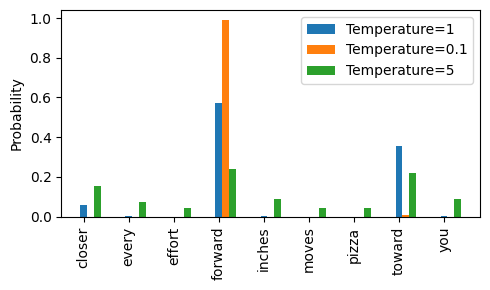

In [47]:
import matplotlib.pyplot as plt
x= torch.arange(len(vocab))
bar_width=0.15
fig,ax= plt.subplots(figsize=(5,3))
for i,T in enumerate(temperatures):
  rects= ax.bar(x+i*bar_width,scaled_probas[i],bar_width,label=f'Temperature={T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(),rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [48]:
#top k sampling
top_k=3
top_logits, top_pos= torch.topk(next_token_logits,top_k)
print(top_logits)
print(top_pos)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [49]:
new_logits= torch.where(
    condition= next_token_logits< top_logits[-1],
    input= torch.tensor(float("-inf")),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [50]:
topk_probas= torch.softmax(new_logits,dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [56]:
#merge temperature scaling and top-k sampling
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [57]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?" I meant to do the picture for nothing--so it with equ out
